## Hyperparameter GridSearchCV - Base Model Titik Panas Sumatera Selatan 2001 - 2023

In [1]:
# pustaka manipulasi data array
import numpy as np

# pustaka manipulasi data frame
import pandas as pd
import random as rm
import time as tm

# pustaka untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# library algorithm lstm-rnn with keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# pustaka untuk  evaluasi model prediksi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Setting seed
rm.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

### 1. Akuisisi Data

In [4]:
# Set waktu komputasi
start = tm.time()

In [5]:
dataset = pd.read_csv("dataset/dataset_hotspot.csv", parse_dates=["acq_date"])

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  276 non-null    datetime64[ns]
 1   hotspot   276 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.4 KB


In [7]:
print(dataset)

      acq_date  hotspot
0   2001-01-31        3
1   2001-02-28        5
2   2001-03-31       10
3   2001-04-30       20
4   2001-05-31       39
..         ...      ...
271 2023-08-31      186
272 2023-09-30     2247
273 2023-10-31     3200
274 2023-11-30      390
275 2023-12-31       42

[276 rows x 2 columns]


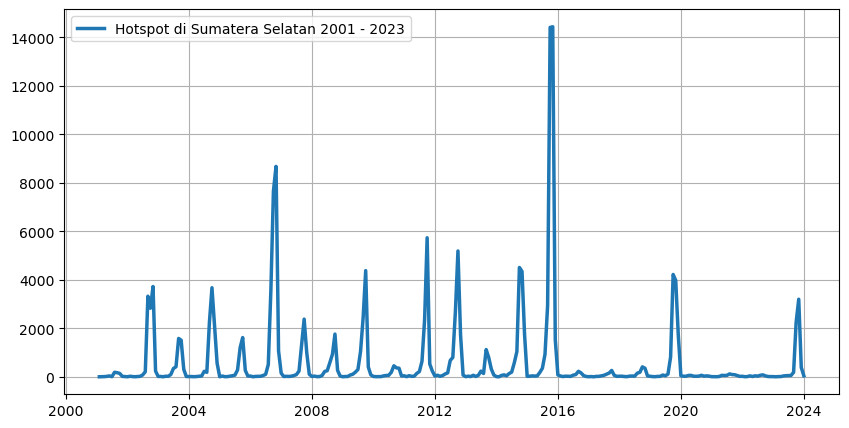

In [9]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], dataset["hotspot"], color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 2. PraProses Data

- seleksi fitur

In [11]:
# hanya memperhatikan aspek hotspot
data = dataset.filter(["hotspot"])
data = data.values

In [12]:
# hasil seleksi fitur
np.round(data[:5],7)

array([[ 3],
       [ 5],
       [10],
       [20],
       [39]], dtype=int64)

In [13]:
# cek dimensi normalisasi
data.shape

(276, 1)

- Normalisasi Data

In [15]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(np.array(data))

In [14]:
# cek dimensi normalisasi
scaled.shape

NameError: name 'scaled' is not defined

### 6. Hyperparameter GridSearchCV LSTM-RNN

- library for hyperparameter

In [ ]:
import itertools
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

- set models lstm-rnn with sliding windows and timestep

In [ ]:
# function models lstm-rnn
def get_model(activation='tanh', optimizer='adam', dropout_rate=0.0):
    
    # reset of session model
    tf.keras.backend.clear_session()
    
    # design network
    model = Sequential()
    
    # first LSTM-RNN layer with dropout regularisation
    model.add(LSTM(units=10, activation=activation, input_shape=(trainX.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    
    # the output layer
    model.add(Dense(1))

    # compiling model the LSTM-RNN
    model.compile(
        optimizer=optimizer,
        loss="mae",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanSquaredError(),
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )
    
    # return value
    return model

Set parameter
- activation function = tanh, sigmoid, relu, selu, softplus, elu.
- optimizers = adam, adamax, rmsprop, sgd.
- droupout = 0.00, 0.05, 0.1, 0.15, 0.2, 0.25
- batch size = 2, 4, 8, 16, 32, 64
- epoch = 500, 1000, 1500, 2000

In [ ]:
# set parameter activation
activation = ['tanh', 'sigmoid', 'relu', 'selu', 'elu', 'softplus']

In [ ]:
# set parameter optimizer
optimizer = ['adam', 'adamax', 'rmsprop', 'sgd']

In [ ]:
# set parameter dropout_rate
dropout_rate = [0.05, 0.1, 0.15, 0.2, 0.25]

In [ ]:
# set parameters batch sizes
batch_size = [2, 4, 8, 16, 32]

In [ ]:
# set parameter epochs
epochs = [2000]

In [ ]:
# set all parameter to dictionary
param_grid = dict(
    model__activation=activation,
    model__optimizer=optimizer,
    model__dropout_rate=dropout_rate,
    batch_size=batch_size,
    epochs=epochs
)

In [ ]:
# show parameter a gridsearch
param_grid

In [ ]:
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(len(combinations), str('kombinasi hyperparameter'))

In [ ]:
# set grid model with KerasRegressor
grid_model = KerasRegressor(model=get_model, verbose=1)

In [ ]:
# process a gridsearchCV
grid_search = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=6, cv=2, scoring='neg_root_mean_squared_error')

In [ ]:
# show a result gridsearchCV
grid_result = grid_search.fit(trainX, trainY)

In [ ]:
# summarize results
print("Best parameters: %f using %s\n" % (grid_search.best_score_, grid_search.best_params_))

In [ ]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
result = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["score"])],axis=1)

In [ ]:
result.sort_values(by="score", ascending=False)

In [ ]:
result.sort_values(by="score", ascending=False).to_csv('gridsearch_percobaan1.csv',index=False)

### Evaluasi Model Prediksi

- kompleksitas waktu

In [ ]:
# Set akhir waktu komputasi 
end = time.time()

In [ ]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [ ]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))